# Influential Spreader Analysis

In [3]:
import EoN
import os
import scipy

import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import statsmodels.api as sm

from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from tqdm import tqdm
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

np.random.seed(0)

plt.rcParams['text.usetex'] = True

In [4]:
email_graph = nx.read_edgelist('../data/email-univ.edges')

In [5]:
def infect_network(G: nx.Graph, tau: float, gamma: float, n: int = 100) -> list:
    """
    Return a list of outbreak sizes averaged over n realizations
    for a SIR model seeded at each graph node

    G: graph
    tau: transmission rate per edge
    gamma: recovery rate per node
    n: monte carlo iterations
    """
    nodes = G.nodes()
    network_size = len(nodes)
    outbreak_by_seed = []
    for node in tqdm(nodes, leave=False):
        outbreak_size = []
        for _ in range(n):
            _, _, _, R = EoN.fast_SIR(G, tau, gamma, initial_infecteds=node)
            outbreak_size.append(R[-1])
        outbreak_by_seed.append(np.mean(outbreak_size))
    return outbreak_by_seed

### Estimate $R_0$

https://epidemicsonnetworks.readthedocs.io/en/latest/functions/EoN.estimate_R0.html

In [6]:
gamma = 1/15
beta = 1/20
effective_infection_rate = beta/gamma
tau = beta/len(email_graph)
print(EoN.estimate_R0(email_graph, tau=tau, gamma=gamma))

0.011700714615547513


In [7]:
get_degree_list = lambda G: np.array(list(dict(G.degree()).values()))
get_moment = lambda G, m: np.mean([G.degree(i)**m for i in G.nodes])

In [8]:
mean_degree = get_moment(email_graph, 1)
var_degree = get_moment(email_graph, 2)
epidemic_threshold = mean_degree/(var_degree)
print(epidemic_threshold)

0.053511475860444115


In [9]:
outbreak_by_node = infect_network(email_graph, tau, gamma, n=100)

## Simulation

Create file if does not exists

In [10]:
try:
    outbreak_df = pd.read_csv('../data/outbreak/outbreak_by_tau_.csv', index_col=0)
except Exception:
    outbreak_by_tau = {}
    for tau in tqdm(np.arange(0.001, 0.11, 0.01)):
        # _, _, _, R = EoN.fast_SIR(email_graph, tau, gamma)
        outbreak_by_node = infect_network(email_graph, tau, gamma, n=100)
        beta = tau * len(email_graph)
        effective_infection_rate = beta/gamma
        outbreak_by_tau[np.round(tau,5)] = outbreak_by_node
    outbreak_df = pd.DataFrame(outbreak_by_tau)

tau_list = list(outbreak_df.columns)

In [11]:
outbreak_df

,0.001,0.011,0.021,0.031,0.041,0.051,0.061,0.071,0.081,0.091,0.101
0,1.48,369.55,663.99,745.51,862.26,915.58,966.05,935.21,989.20,1000.36,1038.28
1,1.50,377.28,664.07,825.32,844.67,943.77,966.85,973.53,999.82,956.37,1007.56
2,1.68,423.72,723.68,808.16,842.82,920.49,946.79,1003.49,1007.43,1019.38,1019.37
3,1.68,382.55,662.76,806.44,874.28,903.81,937.03,933.79,957.61,991.29,988.08
4,1.17,246.60,592.49,711.41,818.83,836.69,806.53,965.03,977.61,947.12,1007.02
...,...,...,...,...,...,...,...,...,...,...,...
1128,1.03,24.42,79.85,167.43,269.95,251.02,386.75,403.43,376.57,514.88,458.79
1129,1.01,12.16,39.35,79.95,206.32,241.64,277.17,422.79,448.41,444.23,520.02
1130,1.00,12.55,32.31,142.20,243.05,261.22,286.37,321.90,397.79,422.75,499.96
1131,1.01,7.11,48.49,124.33,112.55,251.60,356.15,393.02,398.97,484.34,613.28


### Visualizing Epidemic Threshold

Text(0.5, 1.0, 'Epidemic Spreading')

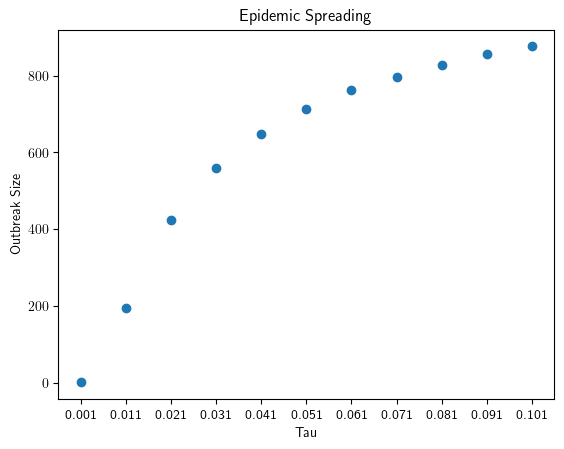

In [12]:
plt.xlabel('Tau')
plt.ylabel('Outbreak Size')
plt.scatter(outbreak_df.columns, [np.mean(outbreak_df[tau]) for tau in tau_list])
plt.title('Epidemic Spreading')

### Regression analysis

In [88]:
def characterize_nodes(G: nx.Graph) -> pd.DataFrame:
    network_metrics = {
        'degree': nx.degree_centrality,
        'clustering': nx.clustering,
        'closeness': nx.closeness_centrality,
        'betweenness': nx.betweenness_centrality,
        'pagerank': nx.pagerank,
        'kcore': nx.core_number
    }

    feature_dict = {}
    for metric in network_metrics:
        feature_dict[metric] = network_metrics[metric](G)
    
    return pd.DataFrame(feature_dict)

In [228]:
feature_df = characterize_nodes(email_graph)

In [150]:
for column in feature_df.columns:
    feature_df[f'log_{column}'] = np.log(feature_df[column])

/home/vitor/Documents/SpreaderInference/venv/lib/python3.13/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/vitor/Documents/SpreaderInference/venv/lib/python3.13/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [159]:
feature_df.replace([np.inf, -np.inf], np.nan, inplace=True)
feature_df = feature_df.dropna(axis=1, how='any')
feature_df.head()

/tmp/ipykernel_217695/2139222015.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  feature_df.replace([np.inf, -np.inf], np.nan, inplace=True)


,degree,clustering,closeness,betweenness,pagerank,kcore,log_degree,log_closeness,log_pagerank,log_kcore
2,0.020318,0.292490,0.327073,0.007507,0.002050,10,-3.896247,-1.117572,-6.190078,2.302585
1,0.026502,0.227586,0.349707,0.008363,0.002246,10,-3.630544,-1.050661,-6.098656,2.302585
3,0.033569,0.196302,0.366699,0.010189,0.002727,10,-3.394155,-1.003214,-5.904619,2.302585
4,0.019435,0.264069,0.326696,0.005032,0.001728,9,-3.940699,-1.118727,-6.360977,2.197225
5,0.008834,0.088889,0.315496,0.001348,0.000846,8,-4.729156,-1.153609,-7.075579,2.079442


In [160]:
scaler = MinMaxScaler()
feature_df = pd.DataFrame(scaler.fit_transform(feature_df), columns=feature_df.columns)

In [161]:
def get_heat_kernel(G: nx.Graph, t: float):
    laplacian = nx.normalized_laplacian_matrix(G).toarray()
    heat_kernel = scipy.linalg.expm(-t*laplacian)
    return heat_kernel

### Cross Validation for HyperParameter

In [231]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression

In [254]:
scores = []

t_list = np.arange(0, 1.5, 0.1)

for t in tqdm(t_list):
    score = 0
    heat_kernel = get_heat_kernel(email_graph, t)
    for tau in tau_list:
        outbreak_by_node = outbreak_df[tau]
        score += np.mean(cross_val_score(LinearRegression(), heat_kernel @ feature_df, outbreak_by_node, cv=10))
    scores.append(score/11)
    
print(f"Max score={np.max(scores)} with t={t_list[np.argmax(scores)]}")

100%|██████████| 15/15 [00:25<00:00,  1.68s/it]

Max score=0.801523614236634 with t=0.30000000000000004


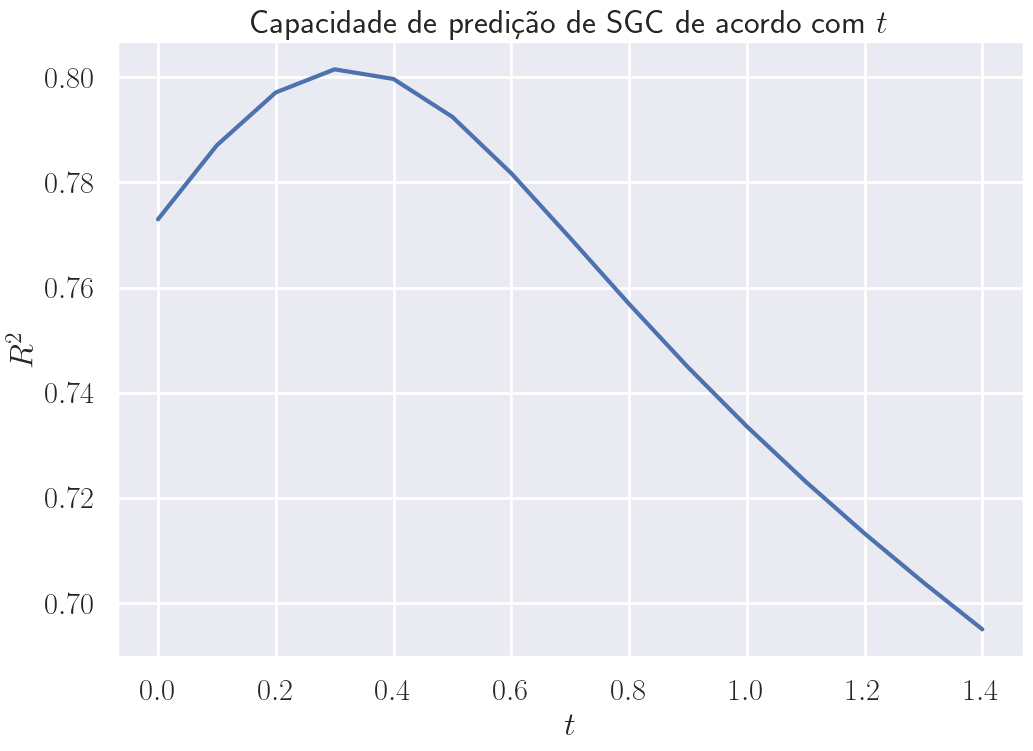

In [265]:
sns.set_theme(context='poster')
sns.lineplot(x=t_list, y=scores)
plt.title('Capacidade de predição de SGC de acordo com $t$')
plt.ylabel('$R^2$')
plt.xlabel('$t$')
plt.savefig('scatter.png', transparent=True, dpi=150)

In [233]:
models = {
    'RF': RandomForestRegressor(),
    'LR': LinearRegression()
}

results = {}

for tau in tqdm(tau_list):
    outbreak_by_node = outbreak_df[tau]
    results_by_tau = {}
    for model in models:
        scores = cross_val_score(models[model], feature_df, outbreak_by_node, cv=10, scoring='r2')
        results_by_tau[model] = np.mean(scores)
    results[tau] = results_by_tau

100%|██████████| 11/11 [01:01<00:00,  5.58s/it]


In [237]:
model = LinearRegression()
heat_kernel = get_heat_kernel(email_graph, 0.5)

for tau in tqdm(tau_list):
    outbreak_by_node = outbreak_df[tau]
    scores = cross_val_score(model, np.log(heat_kernel @ feature_df), outbreak_by_node, cv=10, scoring='r2')
    results[tau]['SGC'] = np.mean(scores)

100%|██████████| 11/11 [00:01<00:00,  9.49it/s]


In [238]:
results_df = pd.DataFrame(results)
results_df

,0.001,0.011,0.021,0.031,0.041,0.051,0.061,0.071,0.081,0.091,0.101
RF,0.720839,0.876517,0.914513,0.917553,0.917323,0.914756,0.907257,0.909105,0.900659,0.892453,0.890161
LR,0.750676,0.876990,0.891683,0.843952,0.808396,0.782072,0.741428,0.744721,0.706605,0.695746,0.660530
SGC,-0.027759,0.735368,0.926208,0.919427,0.904798,0.892587,0.864051,0.872991,0.855325,0.840313,0.810126


<Axes: ylabel='0.011'>

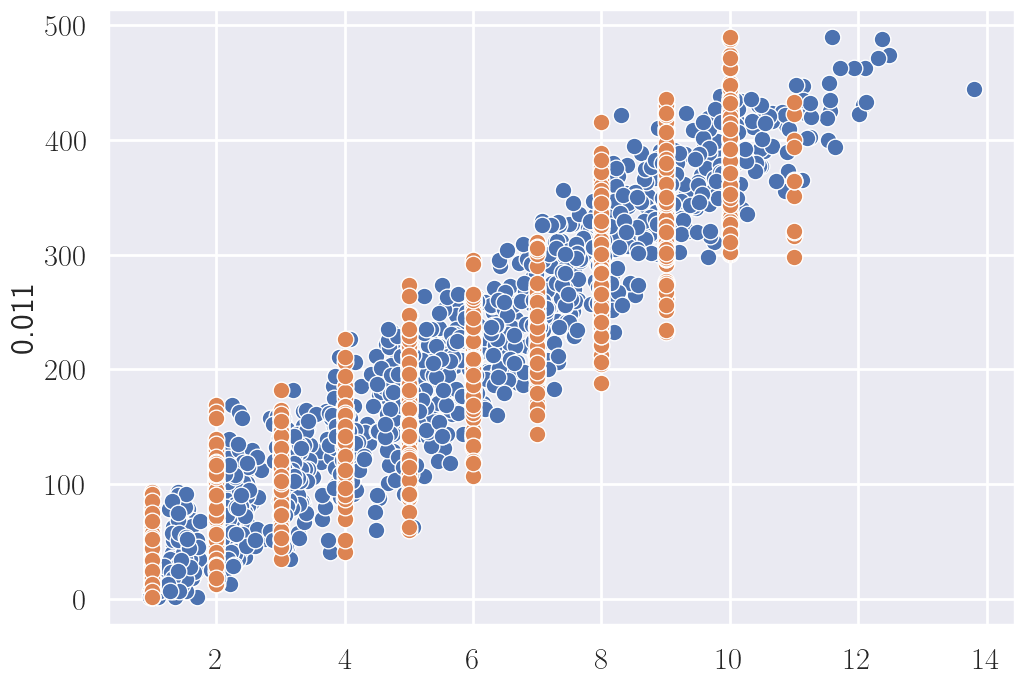

In [ ]:
sns.scatterplot(x=heat_kernel @ np.array(feature_df.kcore), y=outbreak_df['0.011'])
sns.scatterplot(x=np.array(feature_df.kcore), y=outbreak_df['0.011'], )

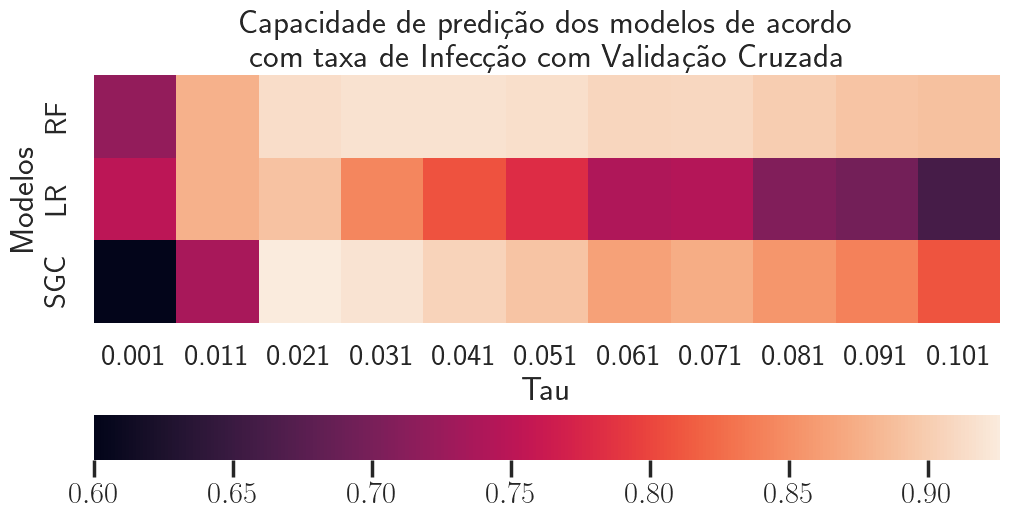

In [243]:
sns.set_theme(rc={'figure.figsize':(11.7,8)}, context='poster')
sns.heatmap(results_df, square=True, cbar_kws={"orientation": "horizontal"}, vmin=0.6)
plt.ylabel('Modelos')
plt.xlabel(r'Tau')
plt.title('Capacidade de predição dos modelos de acordo\ncom taxa de Infecção com Validação Cruzada')
plt.savefig('output.png', transparent=True, dpi=150)

### Feature Selection

Below the threshold, the disease dies quickly, so degree is more important. Instead, when the disease spread, centrality becomes more important

In [168]:
from sklearn.feature_selection import SequentialFeatureSelector

heat_kernel = get_heat_kernel(email_graph, 1)

for tau in tau_list:
    outbreak_by_node = outbreak_df[tau]

    sfs = SequentialFeatureSelector(
        LinearRegression(), 
        n_features_to_select=1,
        cv=10
    )

    sfs.fit(heat_kernel @ feature_df, outbreak_by_node)
    chosen_features = sfs.get_support()
    print(f'tau = {tau}, {feature_df.columns[chosen_features][0]}')

tau = 0.001, degree
tau = 0.011, kcore
tau = 0.021, log_kcore
tau = 0.031, log_kcore
tau = 0.041, log_kcore
tau = 0.051, log_kcore
tau = 0.061, log_kcore
tau = 0.071, log_kcore
tau = 0.081, log_kcore
tau = 0.091, log_kcore
tau = 0.101, log_kcore


<Axes: xlabel='log_kcore', ylabel='0.061'>

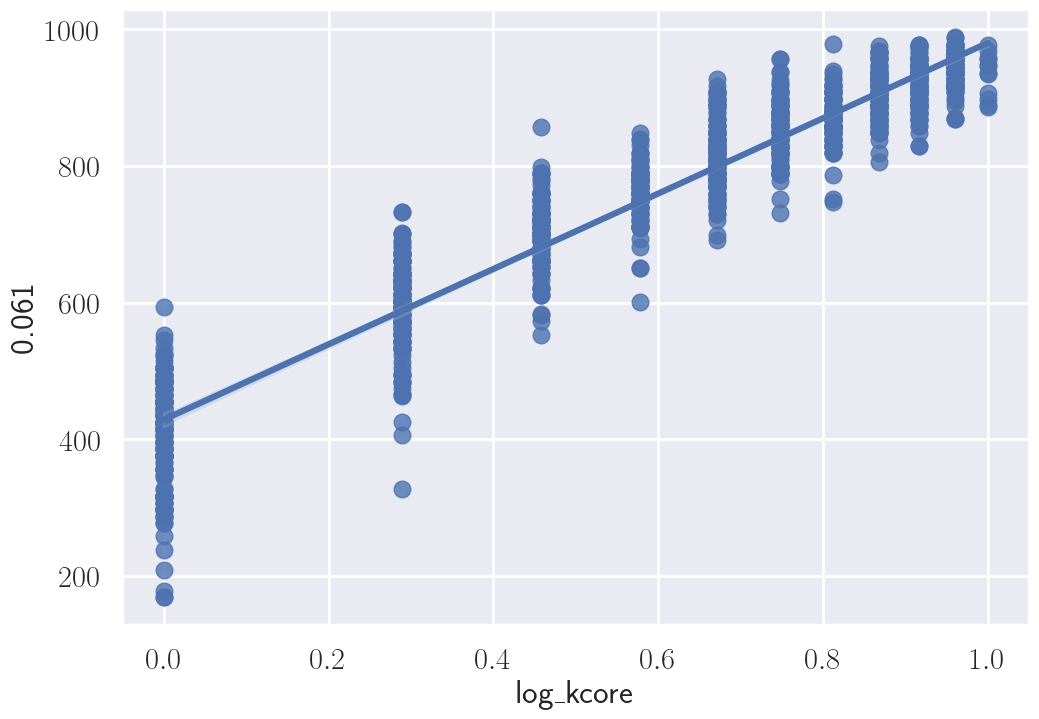

In [182]:
sns.regplot(
    x=feature_df.log_kcore,
    y=outbreak_by_node
)

In [222]:
outbreak_by_node = outbreak_df['0.061']
results = sm.OLS(
    outbreak_by_node, 
    sm.add_constant(heat_kernel @ feature_df[['kcore']])
).fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                  0.061   R-squared:                       0.773
Model:                            OLS   Adj. R-squared:                  0.773
Method:                 Least Squares   F-statistic:                     3848.
Date:                Sun, 04 May 2025   Prob (F-statistic):               0.00
Time:                        14:56:36   Log-Likelihood:                -6663.6
No. Observations:                1133   AIC:                         1.333e+04
Df Residuals:                    1131   BIC:                         1.334e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        508.5778      4.820    105.505      0.0

<Axes: ylabel='0.061'>

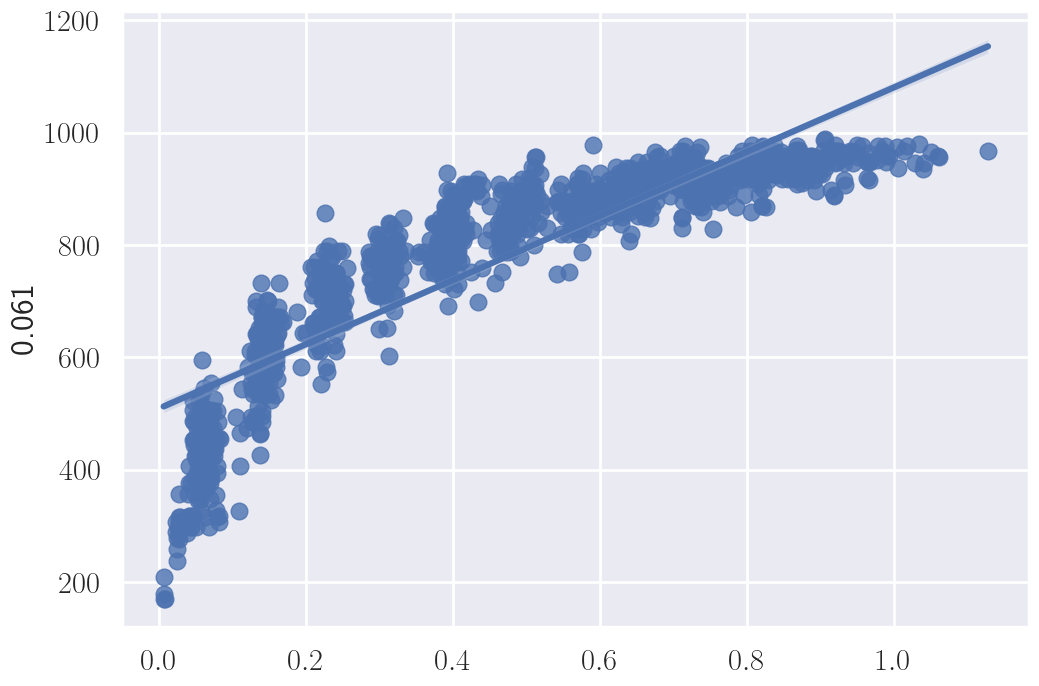

In [223]:
heat_kernel = get_heat_kernel(email_graph, 0.5)

sns.regplot(
    y=outbreak_by_node,
    x=heat_kernel @ feature_df.kcore
)

In [171]:
t_test_dict = {}

for tau in tqdm(tau_list):
    outbreak_by_node = outbreak_df[tau]
    results = sm.OLS(
        outbreak_by_node, 
        sm.add_constant(heat_kernel @ feature_df[['kcore']])
    ).fit()

    t_test = results.t_test('kcore')

    t_test_dict[tau] = {
        'R2': float(results.rsquared),
        'Intercept': float(results.params.const),
        'Coef.': float(results.params.kcore),
        't': float(t_test.tvalue[0][0]),
        'p-value': float(t_test.pvalue)
    }

100%|██████████| 11/11 [00:00<00:00, 100.31it/s]


In [92]:
t_test_df = pd.DataFrame(t_test_dict)
t_test_df.round(2)

,0.001,0.011,0.021,0.031,0.041,0.051,0.061,0.071,0.081,0.091,0.101
R2,0.75,0.93,0.90,0.85,0.81,0.78,0.75,0.74,0.71,0.70,0.68
Intercept,0.87,-21.44,96.41,219.82,315.98,397.56,467.74,521.65,568.57,611.18,644.96
Coef.,0.06,40.40,61.42,63.33,62.09,58.78,54.90,51.59,48.43,45.61,43.24
t,57.88,119.53,101.37,80.07,69.27,62.61,58.46,56.06,52.70,51.20,48.97
p-value,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


Text(0, 0.5, 'Coeficientes de K-Core')

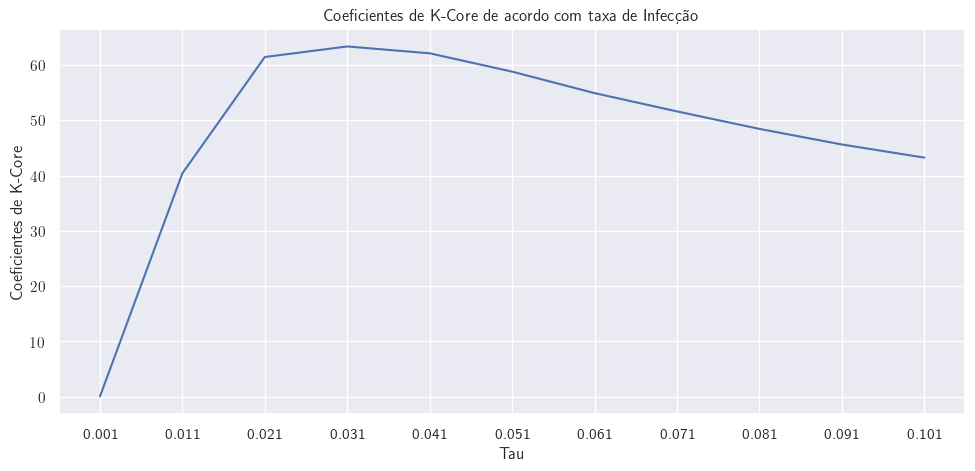

In [110]:
sns.set_theme(rc={'figure.figsize':(11.7,5)})
sns.lineplot(t_test_df.T['Coef.'])
plt.title('Coeficientes de K-Core de acordo com taxa de Infecção')
plt.xlabel('Tau')
plt.ylabel('Coeficientes de K-Core')

<Axes: xlabel='kcore', ylabel='0.061'>

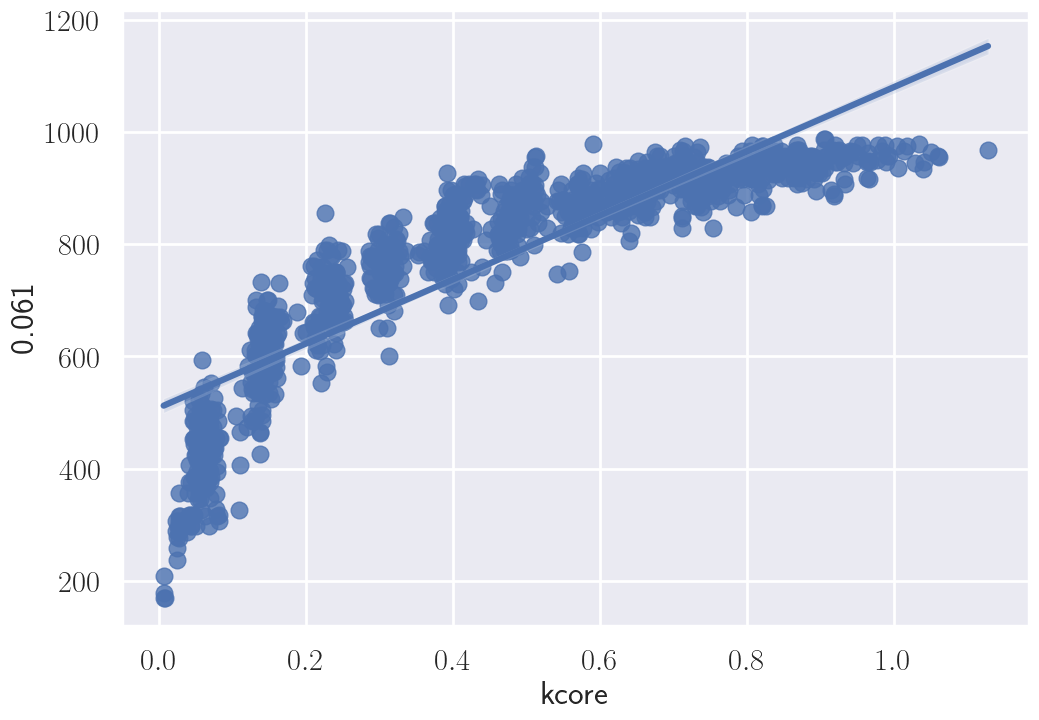

In [227]:
sns.regplot(x=heat_kernel @ feature_df[['kcore']], y=outbreak_df['0.061'])

### Network Characterization

In [278]:
len(email_graph)

1133

In [280]:
len(email_graph.edges())

5451

In [275]:
np.mean(list(dict(email_graph.degree()).values()))

np.float64(9.62224183583407)

In [277]:
nx.degree_assortativity_coefficient(email_graph)

0.07820096256581359

In [281]:
nx.diameter(email_graph)

8

In [284]:
def get_shortest_paths_list(G: nx.Graph) -> list[int]:
    shortest_paths_list = []
    node_list = list(G.nodes)
    for i in tqdm(node_list):
        for j in node_list:
            if i < j:
                shortest_paths_list.append(
                    len(nx.shortest_path(G, i, j)) - 1
                )
    return shortest_paths_list

In [285]:
shortest_paths = get_shortest_paths_list(email_graph)

  0%|          | 0/1133 [00:00<?, ?it/s]

100%|██████████| 1133/1133 [00:16<00:00, 68.69it/s]


In [287]:
np.mean(shortest_paths)

np.float64(3.606032017315423)